<a href="https://colab.research.google.com/github/mulraind001/mulraind001.github.io/blob/main/Copy_of_IoT_Workshop_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands-on Exercise
### Anomaly Detection with Deep Learning Techniques


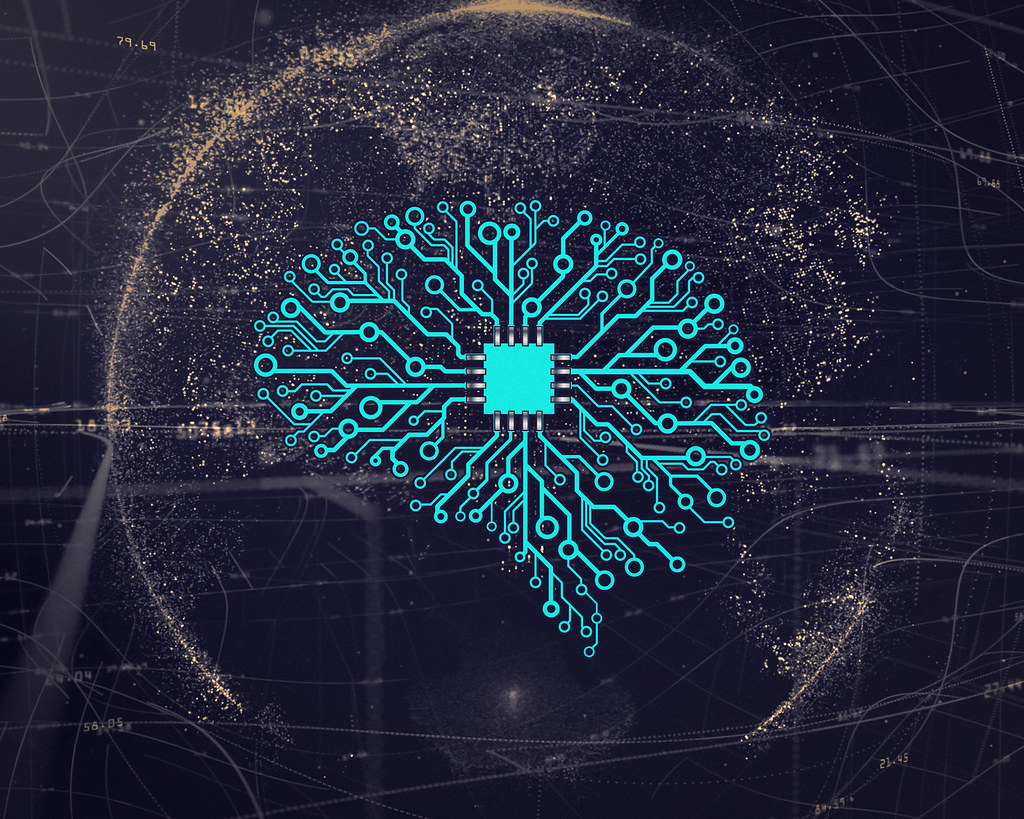




[Link to learn more](https://www.analyticsvidhya.com/blog/2020/03/google-colab-machine-learning-deep-learning/) about Google Colab   Some parts of this exercise is created [by Jeff Heaton](https://sites.wustl.edu/jeffheaton/t81-558/)

In [1]:
# Checking current working directory
!pwd

/content


In [2]:
# Check files in our wdir
!ls

sample_data


In [3]:
### run this cell only when using google cloab ###
# mounting google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


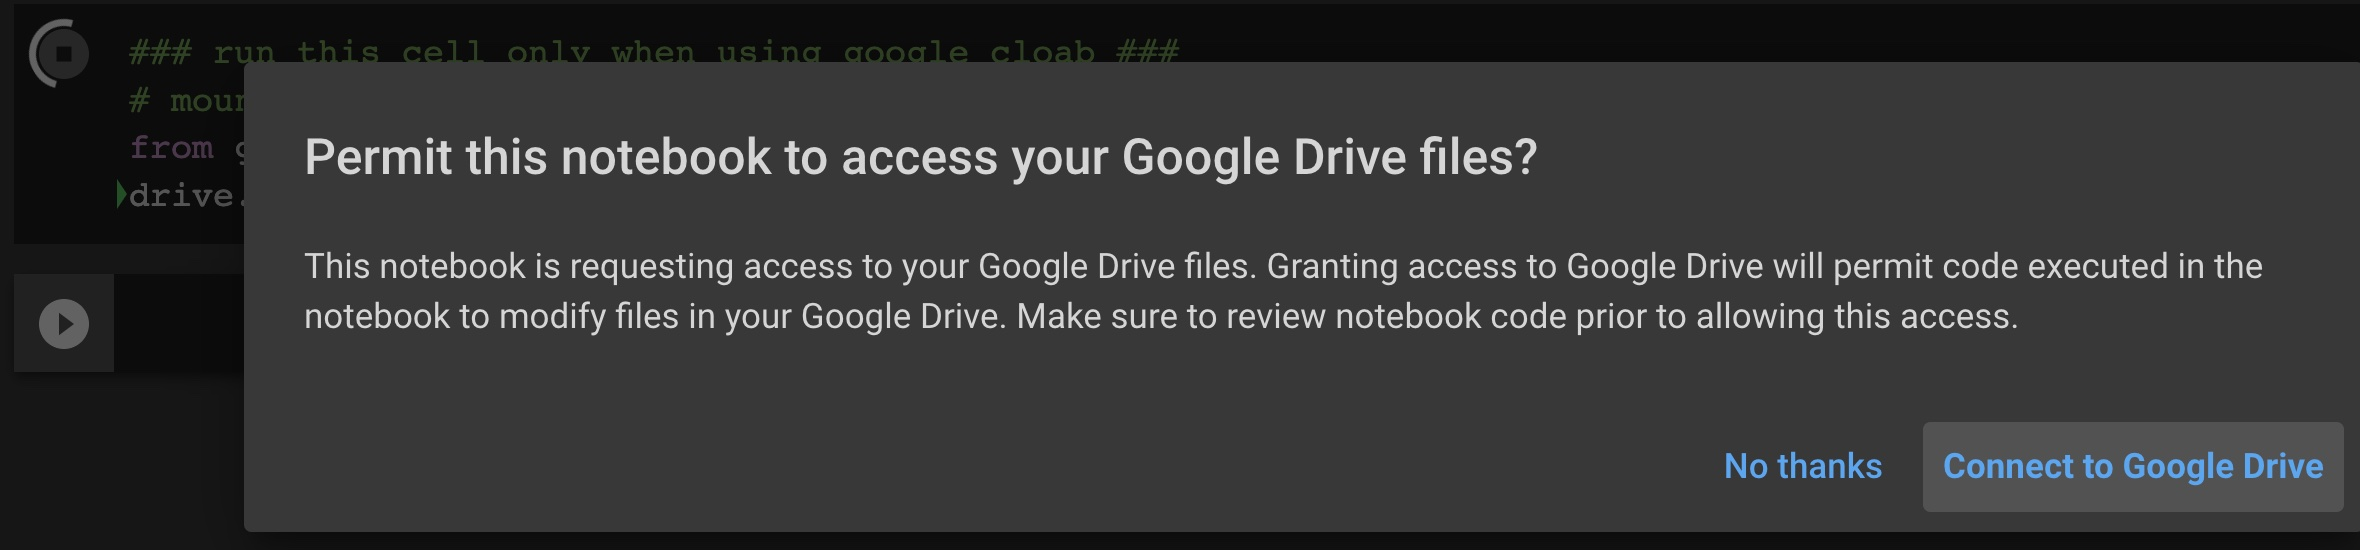

In [4]:
!ls

gdrive	sample_data


In [5]:
import tensorflow as tf

tf.__version__

'2.8.2'

In [6]:
# checking if gpu is available
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[]
False




Training
Dataset Description
To model our intrusion detection learning task we use the KDD99 dataset. The KDD99 dataset is the most widespread IDS(Instrusion Detection System) benchmark dataset. Its compilers extracted 41-dimensional features from a raw dataset called DARPA1998 dataset containing both raw TCP(Transmission Control Protocol) packets and labels. Since raw packets are not of much use for ML models. Because of this reason, a new dataset was curated called KDD99 dataset.

The labels in KDD99 are the same as the DARPA1998. There are four types of features in KDD99, i.e., basic features, content features, host-based statistical features, and time-based statistical features. More about this dataset can be found here: http://kdd.ics.uci.edu/databases/kddcup99/task.html

This dataset can be downloaded from:http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

In the above link, there are several versions of the data set. In this work, we used the full version of the datasets

train data: http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data.gz

test data: http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz

unlabelled data(production data): http://kdd.ics.uci.edu/databases/kddcup99/kddcup.newtestdata_10_percent_unlabeled.gz

column names: http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
We train our model on training set, tune the decision parameters such as classifier threshold and measure the effectiveness metrics on test set (can also be called as validation set). Finally, we use the production set (dataset with no labels) to identify the anomalies. This is helpful bcause when the model goes into production, it mostly would predict on the live data where there are no labels to compare the predictions to.

In [7]:
import pandas as pd
from tensorflow.keras.utils import get_file

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

try:
    path = get_file('kdd-with-columns.csv', origin=\
    'https://github.com/jeffheaton/jheaton-ds2/raw/main/'\
    'kdd-with-columns.csv',archive_format=None)
except:
    print('Error downloading')
    raise
    
print(path) 

# Origional file: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
df = pd.read_csv(path)

print("Read {} rows.".format(len(df)))
# df = df.sample(frac=0.1, replace=False) # Uncomment this line to 
# sample only 10% of the dataset
df.dropna(inplace=True,axis=1) 
# For now, just drop NA's (rows with missing values)


# display 5 rows
pd.set_option('display.max_columns', 5)
pd.set_option('display.max_rows', 5)
df

68141056/68132668 [==============================] - 1s 0us/step
/root/.keras/datasets/kdd-with-columns.csv
Read 494021 rows.


,duration,protocol_type,...,dst_host_srv_rerror_rate,outcome
0,0,tcp,...,0.0,normal.
1,0,tcp,...,0.0,normal.
...,...,...,...,...,...
494019,0,tcp,...,0.0,normal.
494020,0,tcp,...,0.0,normal.


## Data Analyzing

In [8]:
print('different types of services: {}'.format(df['service'].unique()))

different types of services: ['http' 'smtp' 'finger' 'domain_u' 'auth' 'telnet' 'ftp' 'eco_i' 'ntp_u'
 'ecr_i' 'other' 'private' 'pop_3' 'ftp_data' 'rje' 'time' 'mtp' 'link'
 'remote_job' 'gopher' 'ssh' 'name' 'whois' 'domain' 'login' 'imap4'
 'daytime' 'ctf' 'nntp' 'shell' 'IRC' 'nnsp' 'http_443' 'exec' 'printer'
 'efs' 'courier' 'uucp' 'klogin' 'kshell' 'echo' 'discard' 'systat'
 'supdup' 'iso_tsap' 'hostnames' 'csnet_ns' 'pop_2' 'sunrpc' 'uucp_path'
 'netbios_ns' 'netbios_ssn' 'netbios_dgm' 'sql_net' 'vmnet' 'bgp' 'Z39_50'
 'ldap' 'netstat' 'urh_i' 'X11' 'urp_i' 'pm_dump' 'tftp_u' 'tim_i' 'red_i']


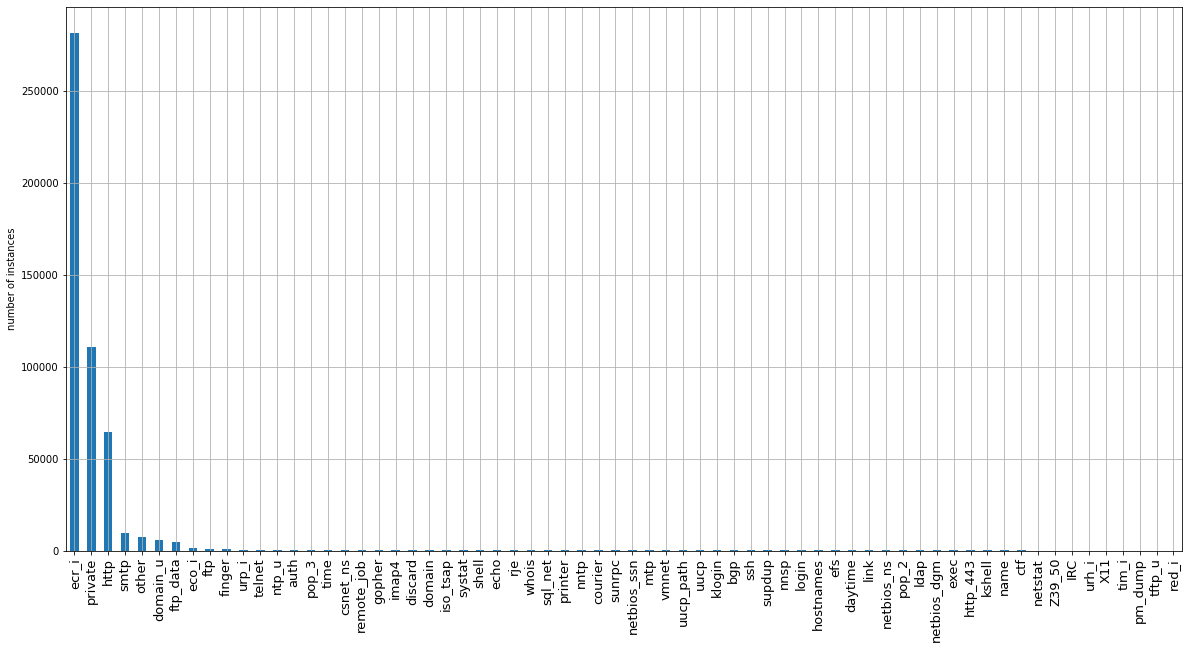

In [9]:
# plot out the spread of services
import matplotlib.pyplot as plt
pd.value_counts(df['service']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

The KDD99 dataset contains many columns that define the network state over time intervals during which a cyber attack might have taken place. The " outcome " column specifies either "normal," indicating no attack, or the type of attack performed. The following code displays the counts for each type of attack and "normal".

In [10]:
df.groupby('outcome')['outcome'].count()

outcome
back.               2203
buffer_overflow.      30
                    ... 
warezclient.        1020
warezmaster.          20
Name: outcome, Length: 23, dtype: int64

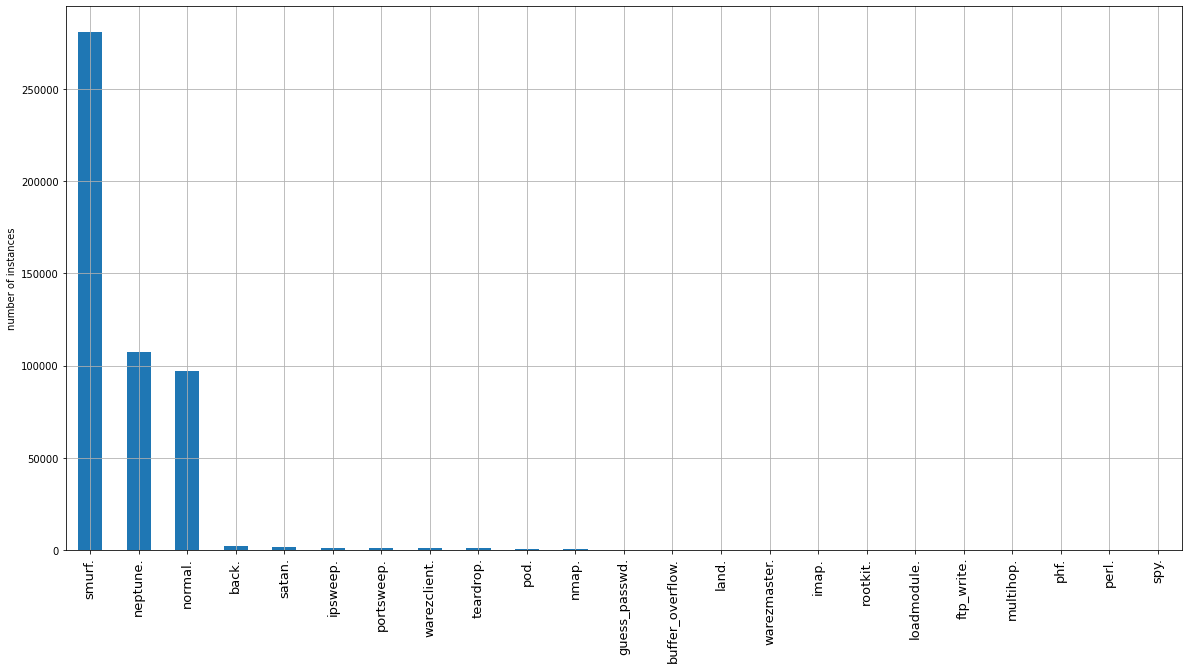

In [11]:
# plot out the spread of outcomes
pd.value_counts(df['outcome']).plot(kind='bar', figsize=(20, 10))
plt.ylabel('number of instances')
plt.xticks(fontsize=13)
plt.grid()
plt.show()

We must perform some preprocessing before we can feed the KDD99 data into the neural network. We provide the following two functions to assist with preprocessing. The first function converts numeric columns into Z-Scores. The second function replaces categorical values with dummy variables.

In [12]:
# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd
    
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] 
# for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = f"{name}-{x}"
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


This code converts all numeric columns to Z-Scores and all textual columns to dummy variables. We now use these functions to preprocess each of the columns. Once the program preprocesses the data, we display the results.

In [13]:
# Now encode the feature vector

pd.set_option('display.max_columns', 6)
pd.set_option('display.max_rows', 5)

for name in df.columns:
  if name == 'outcome':
    pass
  elif name in ['protocol_type','service','flag','land','logged_in',
                'is_host_login','is_guest_login']:
    encode_text_dummy(df,name)
  else:
    encode_numeric_zscore(df,name)    

# display 5 rows

df.dropna(inplace=True,axis=1)
df[0:5]


# Convert to numpy - Classification
x_columns = df.columns.drop('outcome')
x = df[x_columns].values
dummies = pd.get_dummies(df['outcome']) # Classification
outcomes = dummies.columns
num_classes = len(outcomes)
y = dummies.values

We divide the data into two groups, "normal" and the various attacks to perform anomaly detection. The following code divides the data into two data frames and displays each of these two groups' sizes.

In [14]:
normal_mask = df['outcome']=='normal.'
attack_mask = df['outcome']!='normal.'

df.drop('outcome',axis=1,inplace=True)

df_normal = df[normal_mask]
df_attack = df[attack_mask]

print(f"Normal count: {len(df_normal)}")
print(f"Attack count: {len(df_attack)}")

Normal count: 97278
Attack count: 396743


Next, we convert these two data frames into Numpy arrays. Keras requires this format for data.

In [15]:
# This is the numeric feature vector, as it goes to the neural net
x_normal = df_normal.values
x_attack = df_attack.values

## Train the Neural Network

We now train the neural network to classify the different KDD99 outcomes.  The code provided here implements a relatively simple neural with two hidden layers.  We train it with the provided KDD99 data.

In [16]:
import pandas as pd
import io
import requests
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.callbacks import EarlyStopping

# Create a test/train split.  25% test
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(50, input_dim=x.shape[1], activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam')
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)
model.fit(x_train,y_train,validation_data=(x_test,y_test),
          callbacks=[monitor],verbose=2,epochs=10)
        

Epoch 1/10
11579/11579 - 29s - loss: 0.2108 - val_loss: 0.0607 - 29s/epoch - 3ms/step
Epoch 2/10
11579/11579 - 22s - loss: 0.0507 - val_loss: 0.0483 - 22s/epoch - 2ms/step
Epoch 3/10
11579/11579 - 21s - loss: 0.0432 - val_loss: 0.0439 - 21s/epoch - 2ms/step
Epoch 4/10
11579/11579 - 21s - loss: 0.0425 - val_loss: 0.0416 - 21s/epoch - 2ms/step
Epoch 5/10
11579/11579 - 22s - loss: 0.0378 - val_loss: 0.0400 - 22s/epoch - 2ms/step
Epoch 6/10
11579/11579 - 22s - loss: 0.0379 - val_loss: 0.0388 - 22s/epoch - 2ms/step
Epoch 7/10
11579/11579 - 26s - loss: 0.0357 - val_loss: 0.0375 - 26s/epoch - 2ms/step
Epoch 8/10
11579/11579 - 23s - loss: 0.0343 - val_loss: 0.0374 - 23s/epoch - 2ms/step
Epoch 9/10
11579/11579 - 22s - loss: 0.0390 - val_loss: 0.0368 - 22s/epoch - 2ms/step
Epoch 10/10
11579/11579 - 24s - loss: 0.0327 - val_loss: 0.0373 - 24s/epoch - 2ms/step


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                1210      
                                                                 
 dense_1 (Dense)             (None, 50)                550       
                                                                 
 dense_2 (Dense)             (None, 10)                510       
                                                                 
 dense_3 (Dense)             (None, 1)                 11        
                                                                 
 dense_4 (Dense)             (None, 23)                46        
                                                                 
Total params: 2,327
Trainable params: 2,327
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Measure accuracy
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))

Validation score: 0.9903972276650527


# Confusion Matrix
true positives (TP): These are cases in which we predicted yes (they have the disease), and they do have the disease.

true negatives (TN): We predicted no, and they don't have the disease.

false positives (FP): We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

false negatives (FN): We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

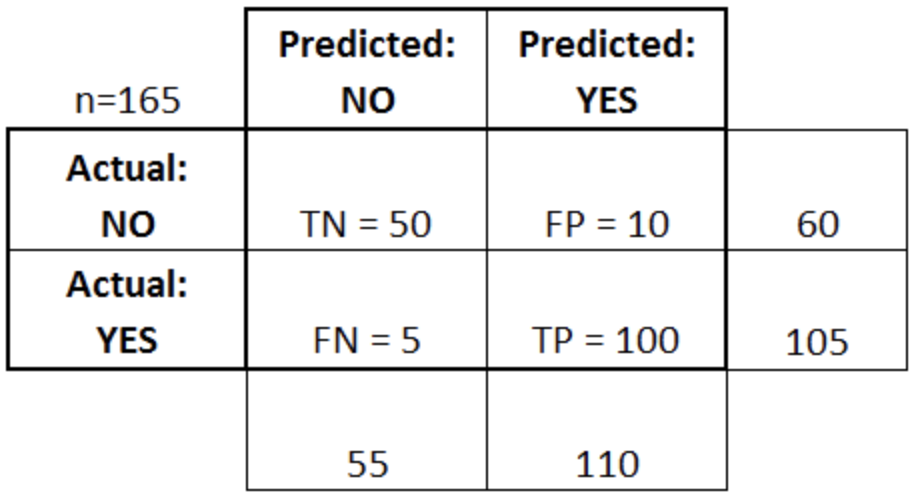